# Práctica 2

## Detección de Anomalías

Usando el dataset de estaturas aplicar detección de anomalías

a. Usar como training-set la primera pestaña de "normales" (y = 0 o sin anomalías)

b. La segunda pestaña "valtest(normales)" contiene datos normales (y = 0 / sin anomalías)

- Usar la mitad para cross-validation
- Usar la mitad para testing

c. La tercera pestaña "valtest(anomalías)" contiene anomalías (y = 1)

- Usar la mitad para cross-validation
- Usar la mitad para testing


In [19]:
import pandas as pd 
import numpy as np 
import random
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

# Se cargan los datos de "estaturas.xlsx"
dfs = pd.read_excel("estaturas.xlsx", sheet_name = None)

# Se obtienen los datos de "entrenamiento"
train_data = dfs["normales"]

# Se obtienen los datos de prueba con y sin anomalías
valtest_data_pos = dfs["anomalias"]
valtest_data_neg = dfs["valtest(normales)"]

# Se cambian los nombres de las columnas en los valores negativos
valtest_data_neg = valtest_data_neg.set_axis(["Estatura", "Edad"], axis=1)

# Se "shufflean" las filas de los dos dataframes
valtest_data_pos = valtest_data_pos.sample(frac=1).reset_index(drop=True)
valtest_data_neg = valtest_data_neg.sample(frac=1).reset_index(drop=True)

# La primera mitad de los valores se utilizan para validación
val_data_pos = valtest_data_pos.iloc[:len(valtest_data_pos)//2, :]
val_data_neg = valtest_data_neg.iloc[:len(valtest_data_neg)//2, :]
val_data = pd.concat([val_data_pos, val_data_neg])

# La segunda mitad de los valores se utilizan para test
test_data_pos = valtest_data_pos.iloc[len(valtest_data_pos)//2 :, :]
test_data_neg = valtest_data_neg.iloc[len(valtest_data_neg)//2 :, :]
test_data = pd.concat([test_data_pos, test_data_neg])

# Arrays con los valores reales de "atípico o no atípico"
y_true = np.zeros((len(val_data), 1))
y_true[0:len(valtest_data_pos)//2] = 1

# Se incluyen las columnas de labels 
val_data = val_data.assign(Anomalia_True = y_true)
test_data = test_data.assign(Anomalia_True = y_true)

# Se realiza una última "shuffleada" a los datos de prueba y validación
val_data = val_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

Creación de una función de distribución de probabilidad a partir de los datos de entrenamiento, así como una función que retorna la probabilidad de una observación utilizando la media y desviación estándar de dicha distribución. 

In [2]:
# Entrenamiento de modelo (extracción de media y covarianza)
def createDistribution(data):

    # Vector de medias (Dims: 1 x NoVars)
    mu = np.mean(data, axis=0).to_numpy()

    # Matriz de covarianzas (Dims: NoVars x NoVars)
    sigma = np.cov(data.T)

    return mu, sigma

# Función que retorna la probabilidad correspondiente a una muestra
def predictDistribution(mu, sigma, data):

    from scipy.stats import multivariate_normal

    dist = multivariate_normal(mean = mu, cov = sigma)

    return dist.pdf(data)

Se entrena (crea una distribución normal multidimensional) un modelo utilizando la función creada y luego se realiza una predicción de la probabilidad de diferentes muestras propias del dataset de validación.

In [30]:
# Se entrena el modelo
modelo = createDistribution(train_data)

# Se generan predicciones o probabilidades utilizando el dataset de validación
probs = predictDistribution(modelo[0], modelo[1], val_data[["Estatura", "Edad"]])

# Se presentan los resultados
print(val_data.assign(Probabilidades = probs))

   Estatura   Edad  Anomalia_True  Probabilidades
0      0.25  43557            1.0        0.000000
1      1.60     31            0.0        0.060092
2      1.76     32            0.0        0.275183
3      0.15    250            1.0        0.000000
4      1.80     27            0.0        0.185247
5      1.82     30            0.0        0.162041


Según los resultados anteriores, parece que un umbral adecuado para la clasificación sería un valor muy cercano a 0. Por lo tanto, tomando en cuenta que uno de los valores "no atípicos" parece contar con una probabilidad de 0.075, se utilizará un umbral con un valor menor a este número: 0.0005. Debido a que la clasificación es fácilmente conseguida utilizando un umbral simple, no se considera apropiado utilizar una transformación de ningún tipo.

In [23]:
epsilon = 0.0005

Se utiliza el umbral anterior para poder realizar la detección de valores atípicos en el dataset de prueba. Con los resultados obtenidos se calcula el F1 Score

In [29]:
# Se obtienen las probabilidades para cada observación de prueba
probs = predictDistribution(modelo[0], modelo[1], test_data[["Estatura", "Edad"]])

# Se detectan valores atípicos
preds = (probs < epsilon).astype(int)

# Se guardan los resultados en un nuevo dataframe
results = test_data.assign(Anomalia_Pred = preds, Probabilidades = probs)

# Se despliegan los resultados
print(results)

# Se calcula el f1-score de las predicciones
from sklearn.metrics import f1_score
f1 = f1_score(results["Anomalia_True"], results["Anomalia_Pred"])
print("F1 Score:", f1)


   Estatura   Edad  Anomalia_True  Anomalia_Pred  Probabilidades
0    150.00     14            1.0              1        0.000000
1      1.82     25            0.0              0        0.114253
2      1.61     31            0.0              0        0.075409
3      1.79     31            0.0              0        0.232738
4    175.10  43587            1.0              1        0.000000
5      1.60     35            0.0              0        0.038381
F1 Score: 1.0


Dado que se obtuvo un F1 Score de 1, se considera que, al menos para el dataset limitado con el que se contaba, el modelo de detección de anomalías es exitoso. 

## Reducción de Dimensionalidad

Usando el dataset de "fashion MNIST" realizar:

1. PCA sin sci-kit learn para reducir a 2 dimensiones. Anotar la cantidad de varianza preservada.

2. T-SNE con sci-kit learn para reducir a 2 dimensiones.

3. Analizar ambas representaciones, comparar y concluir.

4. Aplicar clustering con sci-kit learn sobre la representación reducida.

5. Ya que este dataset si posee etiquetas "y" (tipo de prenda) analizar si los clusters encontrados tienden a agrupar el mismo tipo de prenda o prendas similares (por ejemplo, se puede graficar cada tipo de prenda de color diferente).

6. Agregar conclusiones finales.

In [10]:
import pandas as pd 
import numpy as np 
import random
from scipy.spatial.distance import cdist
import random
import matplotlib.pyplot as plt 
from celluloid import Camera

# Se cargan los datos de "estaturas.xlsx"
dfs = pd.read_excel("estaturas.xlsx", sheet_name = None)

# Se obtienen los datos de "entrenamiento"
train_data = dfs["normales"]

-----

## K-Means

### Función

In [11]:
def KMeans(data, k = 3, iter_max = 100, animate = 0): 

    # ====================
    # INICIALIZACIÓN
    # ====================

    # Se crea una figura y una "cámara"
    if animate:
        fig = plt.figure()
        camera = Camera(fig)

    # Se inicializan las clases "anteriores" y "actuales"
    old_classes = -np.ones((data.shape[0]))
    classes = -2*np.ones((data.shape[0]))

    # Se eligen "k" índices de "data"
    centroid_inds = random.sample(range(0, len(data)), k)

    # Se extraen los "centroides" a partir de los "k" índices seleccionados al azar
    centroids = data.iloc[centroid_inds, :].to_numpy()

    # Se convierte el dataset de entrenamiento a un array de numpy
    dataset = data.to_numpy()

    # Se inicializa el número de iteraciones
    it = 0

    # Mientras las clases cambien y el número de iteraciones sea
    # menor al threshold máximo
    while not all(old_classes == classes) and (it <= iter_max):

        # ====================
        # DISTANCIAS
        # ====================

        # Se inicializa una matriz vacía y sin columnas de distancias
        distances = np.empty((dataset.shape[0], 0))

        # Se itera sobre cada centroide
        for i in range(0, k):

            # Coordenadas del centroide "i"
            centroid = centroids[i, :]

            # Se redimensiona el centroide "i"
            centroid = np.reshape(centroid, (1, centroid.shape[0]))

            # 1. Se obtienen las distancias de cada centroide al resto de puntos
            # 2. Se trasponen las distancias para obtener un vector columna
            # 3. Se concatena horizontalmente el nuevo vector columna a la matriz de distancias
            distances = np.hstack((distances, cdist(centroid, dataset).T ))


        # ====================
        # CLASES
        # ====================

        # Se toma nota del valor previo de las clases
        old_classes = classes

        # Se utiliza "argmin()" para conseguir el cluster al que pertenece cada punto
        classes = np.argmin(distances, axis = 1)

        # Se calcula el costo, el cual únicamente consiste de la suma de todas
        # las distancias cuadradas de los centroides a sus puntos respectivos
        cost = np.sum(np.min(distances, axis = 1)**2)

        # ====================
        # NUEVOS CENTROIDES
        # ====================

        # Se "vacía" el vector de centroides
        centroids = np.empty((0, dataset.shape[1]))

        # Se itera sobre cada cluster
        for i in range(0, k):

            # 1. Se obtiene la media de todos los puntos de la clase
            # 2. Se asigna este como el nuevo centroide de la clase
            new_centroid = np.mean(dataset[classes == i, :], axis = 0)

            # Se concatenan verticalmente los nuevos centroides
            centroids = np.vstack((centroids, new_centroid))

        # ====================
        # PLOT
        # ====================

        # Plot de los centroides y puntos de cada clase
        if animate: 
            plt.scatter(dataset[:,0], dataset[:,1], c=classes, cmap = "viridis")
            plt.scatter(centroids[:,0], centroids[:,1], s = 150, alpha = 0.6, c = "black")

            # Texto de plot
            plt.xlabel("Altura")
            plt.ylabel("Edad")
            plt.title(f"K-Means \nIteración: {it}")

            # Se toma una foto del plot
            camera.snap()
    
        # Se incrementa el número de iteración
        it += 1

    # Se guarda la animación como un gif
    if animate: 
        animation = camera.animate()
        animation.save(f'animaciones\kmeans_k={k}.gif', writer = "pillow")

    return centroids, cost

### Experimentos: Método del Codo

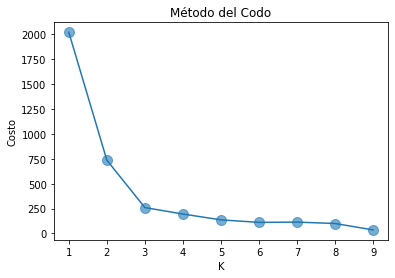

In [12]:
# Se inicializa un vector para almacenar los valores de costo
historial_costo = np.array([])

# Experimentos para el valor de K
for k in range(1,10):

    # Se ejecuta el "K-Means" con la "k" dada
    centroides, costo = KMeans(train_data, k = k, iter_max = 100, animate = 0)

    # Se hace "append" al historial de costo
    historial_costo = np.append(historial_costo, costo)

# Creación de vectores para graficar
x = np.array([range(1,10)], ).T
y = np.reshape(historial_costo, (1, len(historial_costo))).T

plt.plot(x, y)
plt.scatter(x, y, s = 100, alpha = 0.6)
plt.xlabel("K")
plt.ylabel("Costo")
plt.title("Método del Codo")
plt.show()

De acuerdo con la gráfica generada, parece que el valor óptimo para "K" es 3. Al verificar este resultado observando los agrupamientos generados para cada valor de "K" (ver figuras en carpeta "animaciones"), se puede observar que este valor si parece separar de manera correcta los datos según su ubicación física en el plano. Valores más altos se enfocan en conjuntos con formas extrañas y en algunos casos incluso en puntos singulares en el plano. Por lo tanto, en este caso se utilizará un valor de K = 3, ya que el método del codo parece ser efectivo.

A continuación se presentan los resultados obtenidos utilizando una K = 3 (para ver la animación correspondiente ir al archivo "kmeans_k=3.gif" dentro de la carpeta "animaciones").

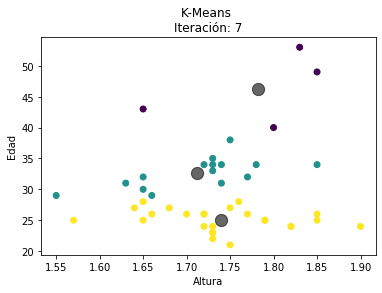

In [13]:
centroides, costo = KMeans(train_data, k = 3, iter_max = 100, animate = 1)

Los resultados parecen ser satisfactorios, con el algoritmo separando a los alumnos de la maestría exclusivamente por su edad. Específicamente los separó en tres grupos o categorías: Personas de 20 a 29 años, de 30 a 39 años y finalmente de 40 a 60 años (siendo este último el menos numeroso). Se intentó con diferentes valores aleatorios iniciales para la posición de los centroides, pero incluso luego de estas pruebas, los puntos tendieron a converger bajo la misma clasificación presentada previamente.

-----

## GMM

Ahora que se obtuvo un valor adecuado para "K" empleando "K-Means" y el método del codo, se emplean estos resultados (específicamente el valor de "K") para resolver el problema de aprendizaje no supervisado utilizando GMM. En este caso, el proceso es mucho más sencillo ya que se hace uso del método ya implementado como parte de Sci-Kit Learn: GaussianMixture

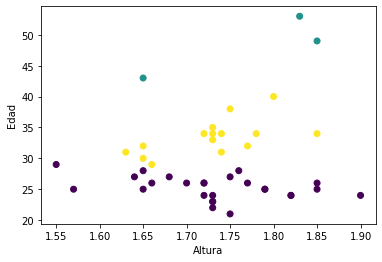

In [15]:
from sklearn.mixture import GaussianMixture

# Se convierte el dataframe en un array de numpy
data = train_data.to_numpy()

# Se ajusta el modelo utilizando GMM y la "K"
# encontrada en los experimentos correspondientes a K-Means
model = GaussianMixture(n_components=3, random_state = 0).fit(data)

# Clases para cada punto
classes = model.predict(data)

# Gráfica de los resultados
plt.scatter(data[:,0], data[:,1], c=classes, cmap = "viridis")
plt.xlabel("Altura")
plt.ylabel("Edad")
plt.show()

Como se puede denotar en la gráfica, los resultados obtenidos empleando 3 "features" o clusters son casi los mismos que los que se obtuvieron utilizando K-Means, lo que valida la implementación realizada para dicho algoritmo. 

-------

## Estimación

Se utilizarán los datos en la segunda pestaña (valtest(normales)) para estimar:

- El cluster que k-means asigna a cada uno.
- La probabilidad de pertenecer a cada cluster según GMM.

In [24]:
# Función para predecir las clases de un conjunto de datos utilizando
# los centroides obtenidos previamente durante el entrenamiento.
def KMeans_predict(data, centroids): 

    # Se obtiene el número de clusters a partir del número de centroides
    k = centroids.shape[0]

    # ====================
    # DISTANCIAS
    # ====================

    # Se inicializa una matriz vacía y sin columnas de distancias
    distances = np.empty((data.shape[0], 0))

    # Se itera sobre cada centroide
    for i in range(0, k):

        # Coordenadas del centroide "i"
        centroid = centroids[i, :]

        # Se redimensiona el centroide "i"
        centroid = np.reshape(centroid, (1, centroid.shape[0]))

        # 1. Se obtienen las distancias de cada centroide al resto de puntos
        # 2. Se trasponen las distancias para obtener un vector columna
        # 3. Se concatena horizontalmente el nuevo vector columna a la matriz de distancias
        distances = np.hstack((distances, cdist(centroid, data).T ))


    # ====================
    # CLASES
    # ====================

    # Se utiliza "argmin()" para conseguir el cluster al que pertenece cada punto
    classes = np.argmin(distances, axis = 1)

    # Se calcula el costo, el cual únicamente consiste de la suma de todas
    # las distancias cuadradas de los centroides a sus puntos respectivos
    cost = np.sum(np.min(distances, axis = 1)**2)

    return classes, cost

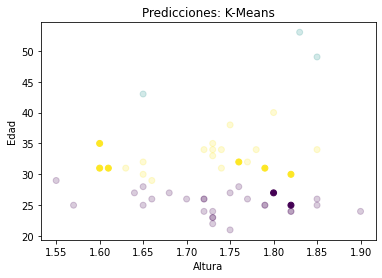

In [48]:
# Se obtienen los datos de prueba
test_data = dfs["valtest(normales)"]

# Se convierten los datos a un array de numpy
test_data = test_data.to_numpy()

# Predecir el cluster al que pertenecen los datos utilizando los centroides anteriores
test_classes, test_cost = KMeans_predict(test_data, centroides)

# Por la forma en la que funciona la función predictora
# los colores de clase están "cambiados" con respecto a los puntos
# originales. Esta línea cambia los colores al cambiar las clases
test_classes[test_classes == 1] = -1
test_classes[test_classes == 2] = 1
test_classes[test_classes == -1] = 2

# Se grafican los resultados
plt.scatter(data[:,0], data[:,1], c=classes, cmap = "viridis", alpha = 0.2)
plt.scatter(test_data[:,0], test_data[:,1], c=test_classes, cmap = "viridis")
plt.xlabel("Altura")
plt.ylabel("Edad")
plt.title("Predicciones: K-Means")
plt.show()

Probabilidades:
 [[1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.22 0.   0.78]
 [0.   0.02 0.98]
 [0.46 0.   0.54]
 [0.   0.   1.  ]
 [0.03 0.   0.97]
 [0.17 0.   0.83]]


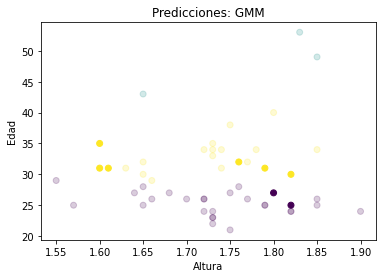

In [38]:
# Predecir el cluster al que pertenecen los datos utilizando los centroides anteriores
test_classes = model.predict(test_data)

# Se imprimen las probabilidades para cada punto
print("Probabilidades:\n", model.predict_proba(test_data).round(2))

# Se grafican los resultados
plt.scatter(data[:,0], data[:,1], c=classes, cmap = "viridis", alpha = 0.2)
plt.scatter(test_data[:,0], test_data[:,1], c=test_classes, cmap = "viridis")
plt.xlabel("Altura")
plt.ylabel("Edad")
plt.title("Predicciones: GMM")
plt.show()

-------

## Generación de Observaciones

Usar GMM y simular 100 observaciones para estimar (estimación de Monte Carlo), el valor esperado (promedio) de la función: f(edad, estatura) = estatura / edad 


In [45]:
# Se generan las muestras aleatorias a partir de las distribuciones creadas 
# durante el entrenamiento del modelo
observaciones = model.sample(n_samples=100)
observaciones = observaciones[0]

# Función de estatura dividido edad
def f(edad, estatura):
    return(estatura / edad)

# Se calcula el valor de la función para las observaciones y luego
# se obtiene la media de los valores generados
val_esperado = np.mean(f(observaciones[:,0], observaciones[:,1]))

# Se imprime el valor esperado
print("Valor Esperado:", val_esperado)

Valor Esperado: 17.42955137669631
